# Modeling Notebook + preprocessing + Advanced topic modeli

In [1]:
#Importing necessary packages and libraries
import twint
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffreyng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jeffreyng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeffreyng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###  Mean word count per tweet is 33.25 words

In [2]:
#importing more necessary packages
from nltk.tokenize import RegexpTokenizer
import re
import string
from nltk.stem import WordNetLemmatizer 

In [3]:
#scraped CSV into dataframe
df=pd.read_csv('jeff.csv')
df.shape

(7137, 35)

### Using Vader Sentiment Analysis to classify the tweets to be positive, neutral, or negative

In [4]:
#importing the vader sentiment analysis package and instantiating it
data=df
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [324]:
#wrote a function to get the vader scores for my data
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)

In [325]:
#list comprehension to get scores from tweets using my written function
a= [analyser.polarity_scores(x) for x in data['tweet']]

In [326]:
a

[{'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'compound': -0.6597},
 {'neg': 0.319, 'neu': 0.681, 'pos': 0.0, 'compound': -0.7925},
 {'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'compound': 0.8832},
 {'neg': 0.303, 'neu': 0.577, 'pos': 0.12, 'compound': -0.5859},
 {'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'compound': 0.7825},
 {'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.8513},
 {'neg': 0.196, 'neu': 0.622, 'pos': 0.182, 'compound': -0.0772},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'compound': -0.6808},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.099, 'neu': 0.901, 'pos': 0.0, 'compound': -0.4515},
 {'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'compound': 0.0258},
 {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.7783},
 {'neg': 0.0, 'ne

In [7]:
#pulling the relevant score into a list 
b= [x.items() for x in a]

In [8]:
#creating a dataframe of my vader scores of the tweets
data1=pd.DataFrame(b, columns= ['neg', 'neu', 'pos', 'comp'])

In [9]:
#putting my scores into a column in the dataframe
b = data1['comp']

In [10]:
b

0       (compound, -0.6597)
1       (compound, -0.7925)
2        (compound, 0.8832)
3       (compound, -0.5859)
4        (compound, 0.7825)
               ...         
7132        (compound, 0.0)
7133    (compound, -0.6597)
7134    (compound, -0.4919)
7135     (compound, 0.1007)
7136     (compound, 0.4019)
Name: comp, Length: 7137, dtype: object

In [11]:
#making a column that grabs the right compound score to gauge sentiment
data1['comp2']= [score[1] for score in b]

In [12]:
k=data1['comp2']

In [13]:
#rounding out my vader score
data1['comp2']= data1['comp2'].round(3)

In [14]:
#converting the vader scores into something easier to manipulate so that I can generate 
#three distinct classes
col         = 'comp2'
conditions  = [ data1[col] >= .05, (data1[col] < .05) & (data1[col]> -.05), data1[col] <= -.05 ]
choices     = [ 1, 0, -1 ]
data1["comp3"] = np.select(conditions, choices, default=np.nan)

In [15]:
#final conversion step of the data to equate vader score with the three class of sentiments
data1['comp4']= data1['comp3'].map({-1:'negative', 0: 'neutral', 1:'positive'})

In [16]:
#concating dataframe of useful items for NLP analysis
main_data= pd.concat([data['tweet'], data['language'], data1['comp4']], axis=1, join='outer')

In [17]:
#grabbing only the tweets in English
Work_data= main_data[main_data['language']=='en']

In [327]:
Work_data.head()

,tweet,language,comp4,spacy_txt,spacy_y
0,https://twitter.com/drawandstrike/status/1279...,en,negative,"( , https://twitter.com/drawandstrike/status/1...",(negative)
1,RACISM IS THE IDOL THAT FEEDS THE BEAST OF #b...,en,negative,"(RACISM, IS, THE, IDOL, THAT, FEEDS, THE, , B...",(negative)
2,Powerful picture of the REAL state of race rel...,en,positive,"(Powerful, picture, of, the, REAL, state, of, ...",(positive)
3,Looks like yet another black criminal dealt wi...,en,negative,"(Looks, like, yet, another, black, criminal, d...",(negative)
4,"I SAW YOU ON THE NEWS, KNOW THE TRUTH AND YOUR...",en,positive,"(I, SAW, YOU, ON, THE, NEWS, ,, KNOW, THE, TRU...",(positive)


In [18]:
Work_data['comp4'].value_counts()

negative    2127
positive    1917
neutral      837
Name: comp4, dtype: int64

### Performing a train, test, split on preprocessed data (no word engineering)

In [19]:
#defining my X variable as well as my target(y)
X= Work_data['tweet']
y= Work_data['comp4']

In [20]:
#train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.20, random_state=23)

In [21]:
X

0        https://twitter.com/drawandstrike/status/1279...
1       RACISM IS THE IDOL THAT FEEDS THE  BEAST OF #b...
2       Powerful picture of the REAL state of race rel...
3       Looks like yet another black criminal dealt wi...
4       I SAW YOU ON THE NEWS, KNOW THE TRUTH AND YOUR...
                              ...                        
7131    For all the #AllLivesMatter people.. I’m gonna...
7133    @ericgarcetti  what did you expect moron? we'r...
7134    Does that mean #DementiaJoe is saying #AllLive...
7135    #PaperMario #PaperMarioTheOrigamiKing #Nintend...
7136     pic.twitter.com/Q1HTj0C8db you can sue for mi...
Name: tweet, Length: 4881, dtype: object

### The main NLP function (tokenization, stop words, lemma)

In [22]:
#created a NLP processing function that includes all the steps of corpus cleaning and creation and
#vectorization
def NLP_process_training_set(data):
    BoW=[]
    for word in data:
        BoW.append(word)
    word_bank= ' '.join(BoW)
    word_bank= word_bank.lower()
#     from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    tokenized_tweets= tokenizer.tokenize(word_bank)

    sw_list = stopwords.words('english')
    sw_list += list(string.punctuation)
    sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—', '.']
    sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter', 'p']
    sw_set = set(sw_list)
    filtered_tweets=[]
    for word in tokenized_tweets:
        if word not in sw_set:
            filtered_tweets.append(word)
#     
    lemmatizer=WordNetLemmatizer()
    X_lemmatized_tweets=[]
    for w in filtered_tweets:
        X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
    
    
    tfidf = TfidfVectorizer(stop_words=sw_set, ngram_range=(1,1), lowercase=True)
    tfidf_data_train_lem = tfidf.fit_transform(X_lemmatized_tweets)
    return tfidf_data_train_lem 
#     tfidf_data_test_lem = tfidf.transform(X_test)

    

In [403]:
#created a NLP processing function that includes all the steps of corpus cleaning and creation and
#vectorization
def NLP_process_testing_set(data):
    word_bank= [' '.join(x) for x in data]
    word_spaced= [x.lower() for x in word_bank]
#     from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    tokenized_tweets= [tokenizer.tokenize(x) for x in word_spaced]

    sw_list = stopwords.words('english')
    sw_list += list(string.punctuation)
    sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—', '.']
    sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter', 'p']
    sw_set = set(sw_list)
    filtered_tweets=[]
    for word in tokenized_tweets:
        if word not in sw_set:
            filtered_tweets.append(word)
#     
    lemmatizer=WordNetLemmatizer()
    X_lemmatized_tweets=[]
    for w in filtered_tweets:
        X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
    return X_lemmatized_tweets
    
#     tfidf = TfidfVectorizer(stop_words=sw_set, ngram_range=(1,1), lowercase=True)
#     tfidf_data_test_lem = tfidf.transform(X_lemmatized_tweets)
#     return tfidf_data_test_lem 

In [404]:
NLP_process_testing_set(Work_data['tweet'])

TypeError: unhashable type: 'list'

In [402]:
tokenized_tweets

NameError: name 'tokenized_tweets' is not defined

### Manually implementing the NLP function piece by piece

In [370]:
pylDaviz
#creating word bank from tweets
# BoW=[]
# for word in X_train:
#     BoW.append(word)
# len(BoW)

In [ ]:
#creating corpus, lowercasing the words, stripping of whitespace
# word_bank= ' '.join(BoW)
# word_bank= word_bank.lower()
# word_bank

In [ ]:
#manually tokenizing the corpus
# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
# tokenized_tweets= tokenizer.tokenize(word_bank)

In [ ]:
# tokenized_tweets

In [25]:
#creating stop words to filter our word bank
import string
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—', ' ', 'bizpacreview', 'ccya4ewhiyi' ,'8bkua22xbjnl']
sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 'u'
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter', 'black', 'lives', 'matter', 'blm', 'alm']
sw_list += [str(x) for x in range(100)]
sw_set = set(sw_list)

In [26]:
#list of stopwords and punctuation
print(sw_set)

{'about', 'again', '^', 'www', 'my', 'how', 'alllivesmatter', "hadn't", 'your', 'be', '61', 'until', 'and', 'nor', 'no', '7', "hasn't", "you'll", '|', 've', '10', 'is', 'shouldn', '64', "it's", '93', 'should', 'wouldn', 'it', 'haven', 'him', '69', '88', 'black', '95', '42', '31', '13', '18', 'did', 'those', 'couldn', '80', '@', 'm', '85', 'mustn', '’', 'these', 'up', 'com', '92', 'ain', 'hasn', "isn't", '-', 'himself', 'for', 'myself', ')', 'do', 'doing', ':', 'themselves', 's', "mustn't", '16', 'any', '8bkua22xbjnl', 'yourselves', '35', "needn't", 'having', 'ccya4ewhiyi', 'they', '33', 'some', 'didn', ',', '_', '32', 'during', 'blm', "haven't", '52', '{', '>', 'with', "wasn't", "you've", 'am', 'from', "''", '36', 'wasn', '20', '.', "won't", ';', 'when', '56', 'yours', '51', '22', '91', '17', '81', "wouldn't", '74', 'just', '43', 'been', 'once', '30', 'what', 'there', '~', 'https', 'out', '96', '38', '99', 'theirs', '27', 'his', 'under', '41', 'through', '*', '68', '``', 'because', '71

In [27]:
#filtering out stopwords
# filtered_tweets=[]
# for word in tokenized_tweets:
#     if word not in sw_set:
#         filtered_tweets.append(word)

In [28]:
#lemmatizing
# from nltk.stem import WordNetLemmatizer 
# lemmatizer=WordNetLemmatizer()
# X_lemmatized_tweets=[]
# for w in filtered_tweets:
#     X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
# print (X_lemmatized_tweets)

In [29]:
#using function to process my data
# X_train= NLP_process(X_train)
# y_train=NLP_process(y_train)

In [30]:
#using function to process data
# X_test=NLP_process(X_test)

### Vectorizing tf-idf and creating the Document Term Matrix

In [31]:
#using tf_idf vectorizer
tfidf = TfidfVectorizer(stop_words=sw_set, ngram_range=(1,3), lowercase=True)
tfidf_data_train_lem = tfidf.fit_transform(X_train)
tfidf_data_test_lem = tfidf.transform(X_test)

dfq = pd.DataFrame(tfidf_data_test_lem.toarray().T,
                 index = tfidf.vocabulary_.keys())
dfq1=dfq.T

In [32]:

m=[dfq1.iloc[i].idxmax() for i in range(977)]



In [33]:
len(m)

977

In [34]:
tuple_S=(zip(y_test, m))


In [35]:
dfq1

,fund,defense,trump2020landslidevictory,fund defense,defense trump2020landslidevictory,fund defense trump2020landslidevictory,dems,ever,get,charge,...,police fridaythoughts,fridaythoughts harden,harden nbabubble,person allblacklivesmatter mutually,allblacklivesmatter mutually exclusive,mutually exclusive minority,exclusive minority police,minority police fridaythoughts,police fridaythoughts harden,fridaythoughts harden nbabubble
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
dict_A=dict(zip(y_test,m))
len(dict_A)

3

In [38]:
Dataframe=pd.DataFrame(dict_A, index= ['sentiment']).T

In [39]:
dfs=Dataframe.reset_index()
dfs

,index,sentiment
0,negative,chose never
1,positive,awakening wwg1wga
2,neutral,christopher columbus


In [40]:
# dict_w= dict(zip(dict_A.values(),dict_A.keys()))
next_list=[]
for key in dict_A.keys():
    if len(key)<1000:
        next_list.append(key)
len(next_list)


3

### Classifying the tweets with a baseline + three models (RF,NB, SVM)

#### Baseline Model

In [41]:
#count vectorizing data for dummy classifier
vec=CountVectorizer(stop_words=sw_set, ngram_range=(1,3), lowercase=True)
X_b=vec.fit_transform(X_train)
X_test_b=vec.transform(X_test)

In [42]:
#fitting and predicting the dummy classifier (baseline model)
from sklearn.dummy import DummyClassifier
dclf = DummyClassifier() 
dclf.fit(X_b, y_train)
y_preds_b=dclf.predict(X_test_b)

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [43]:
#printing the evaluation metrics for the dummy classifier
print(metrics.accuracy_score(y_test, y_preds_b))
print(metrics.precision_score(y_test, y_preds_b, average='weighted'))
print(metrics.recall_score(y_test, y_preds_b, average='weighted'))
print(metrics.f1_score(y_test, y_preds_b, average='weighted'))


0.3623336745138178
0.3660419976254192
0.3623336745138178
0.3637691620179502


#### Random Forest Model

In [44]:
#initializing RandomForest 
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=0, n_jobs=-1)

In [45]:
#fitting model
rfc.fit(tfidf_data_train_lem, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, n_jobs=-1,
                       random_state=0)

In [46]:
tfidf_data_test_lem.shape

(977, 54344)

In [47]:
rfc_cv= RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=0, n_jobs=-1)

In [48]:
rfc_cv.fit(X_b, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, n_jobs=-1,
                       random_state=0)

In [49]:
rfc_cv_preds=rfc_cv.predict(X_test_b)

In [50]:
print(metrics.accuracy_score(y_test, rfc_cv_preds))
print(metrics.precision_score(y_test, rfc_cv_preds, average='weighted'))
print(metrics.recall_score(y_test, rfc_cv_preds, average='weighted'))
print(metrics.f1_score(y_test, rfc_cv_preds, average='weighted'))


0.9160696008188332
0.9188084316640254
0.9160696008188332
0.9166843399432864


In [51]:
#predicting model
rfc_preds= rfc.predict(tfidf_data_test_lem[0:700])
rfc_preds_h= rfc.predict(tfidf_data_test_lem[700: ])

In [52]:
#printing out evaluation metrics
print(metrics.accuracy_score(y_test[0:700], rfc_preds))
print(metrics.precision_score(y_test[0:700], rfc_preds, average='weighted'))
print(metrics.recall_score(y_test[0:700], rfc_preds, average='weighted'))
print(metrics.f1_score(y_test[0:700], rfc_preds, average='weighted'))



0.9014285714285715
0.9059041638633476
0.9014285714285715
0.9024864439956664


In [53]:
#printing out evaluation metrics
print(metrics.accuracy_score(y_test[700: ], rfc_preds_h))
print(metrics.precision_score(y_test[700: ], rfc_preds_h, average='weighted'))
print(metrics.recall_score(y_test[700: ], rfc_preds_h, average='weighted'))
print(metrics.f1_score(y_test[700: ], rfc_preds_h, average='weighted'))

0.8808664259927798
0.8952632813146383
0.8808664259927798
0.8850533395514861


In [55]:
#a comparison of the counts of prediction and actual 
pd.Series(y_test).value_counts()

negative    453
positive    366
neutral     158
Name: comp4, dtype: int64

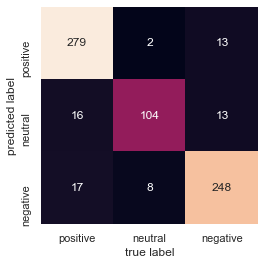

In [56]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test[0:700], rfc_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('true label')
plt.ylabel('predicted label');

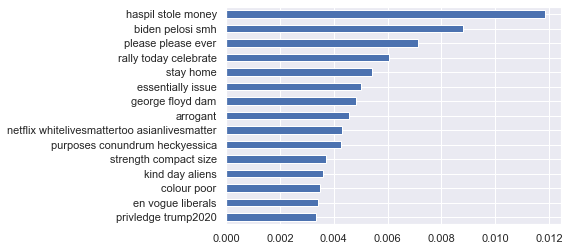

In [130]:
feat_importances= pd.Series(rfc.feature_importances_,index=tfidf.vocabulary_)
feat_importances.nlargest(15).sort_values().plot(kind='barh')
plt.savefig('RFC_feature_importance.png')

#### Multinomial Naive Bayes Model

In [58]:
#Naive Bayes Classifier 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.01, fit_prior=False)

In [59]:
#fitting model with tf_idf vectorized data
clf.fit(tfidf_data_train_lem, y_train)

MultinomialNB(alpha=0.01, fit_prior=False)

In [60]:
#predicting model

clf_preds= clf.predict(tfidf_data_test_lem[0:700])
clf_preds_h= clf.predict(tfidf_data_test_lem[700: ])

In [61]:
#evaluation metrics
print(metrics.accuracy_score(y_test[0:700], clf_preds))
print(metrics.precision_score(y_test[0:700], clf_preds, average='weighted'))
print(metrics.recall_score(y_test[0:700], clf_preds, average='weighted'))
print(metrics.f1_score(y_test[0:700], clf_preds, average='weighted'))

0.8828571428571429
0.8832208473916602
0.8828571428571429
0.8826476413209717


In [62]:
print(metrics.accuracy_score(y_test[700: ], clf_preds_h))
print(metrics.precision_score(y_test[700: ], clf_preds_h, average='weighted'))
print(metrics.recall_score(y_test[700: ], clf_preds_h, average='weighted'))
print(metrics.f1_score(y_test[700: ], clf_preds_h, average='weighted'))

0.8844765342960289
0.8852899411314036
0.8844765342960289
0.8842972510317945


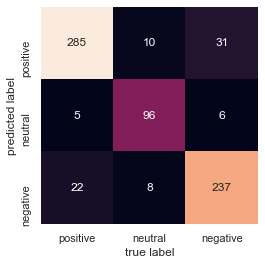

In [63]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test[0:700], clf_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('true label')
plt.ylabel('predicted label');

#### SVM Model

In [64]:
#starting SVM model
from sklearn import svm

In [65]:
#setting hyperparameters for the SVM model
svm_clf = svm.SVC(kernel='linear', C=10, class_weight='balanced')

In [66]:
#fitting the SVM model
svm_clf.fit(tfidf_data_train_lem, y_train)

SVC(C=10, class_weight='balanced', kernel='linear')

In [67]:
#predicting the classification with SVM
svm_preds=svm_clf.predict(tfidf_data_test_lem[0:700])
svm_preds_h=svm_clf.predict(tfidf_data_test_lem[700: ])

In [68]:
#Evaluation metrics
print(metrics.accuracy_score(y_test[0:700], svm_preds))
print(metrics.precision_score(y_test[0:700], svm_preds, average='weighted'))
print(metrics.recall_score(y_test[0:700], svm_preds, average='weighted'))
print(metrics.f1_score(y_test[0:700], svm_preds, average='weighted'))

0.91
0.9107326099083264
0.91
0.9093740379123554


In [69]:
print(metrics.accuracy_score(y_test[700: ], svm_preds_h))
print(metrics.precision_score(y_test[700: ], svm_preds_h, average='weighted'))
print(metrics.recall_score(y_test[700: ], svm_preds_h, average='weighted'))
print(metrics.f1_score(y_test[700: ], svm_preds_h, average='weighted'))

0.9061371841155235
0.9063950489943269
0.9061371841155235
0.9057082358075139


In [70]:
svm_clf_cv=svm.SVC(kernel='linear', C=10, class_weight='balanced')

In [71]:
svm_clf_cv.fit(X_b, y_train)

SVC(C=10, class_weight='balanced', kernel='linear')

In [72]:
svm_clf_cv_preds=svm_clf_cv.predict(X_test_b)

In [73]:
print(metrics.accuracy_score(y_test, svm_clf_cv_preds))
print(metrics.precision_score(y_test, svm_clf_cv_preds, average='weighted'))
print(metrics.recall_score(y_test, svm_clf_cv_preds, average='weighted'))
print(metrics.f1_score(y_test, svm_clf_cv_preds, average='weighted'))

0.8955987717502559
0.9050582406986623
0.8955987717502559
0.8971948483402842


## Getting the SVM coefficients of the count_vectorized data

In [74]:
svm_clf_cv.coef_.T.shape
data4=vec.get_feature_names()

In [75]:
df_CV=pd.DataFrame(svm_clf.coef_.T.todense(), index= data4)

In [76]:
df_CV

,0,1,2
000,0.042496,-0.324458,-0.340698
000 federal,0.048293,0.072245,0.000000
000 federal inmates,0.048293,0.072245,0.000000
000 get,0.000000,-0.144570,-0.121842
000 get help,0.000000,-0.144570,-0.121842
...,...,...,...
سرايا_السلام pic,0.078378,0.089542,0.000000
سرايا_السلام pic zmruclqlf2,0.078378,0.089542,0.000000
태민아_짝궁들이_생일축하한대,-0.243570,0.000000,0.264452
태민아_짝궁들이_생일축하한대 pic,-0.243570,0.000000,0.264452


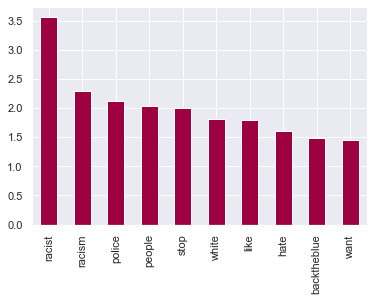

In [77]:
df_CV[0].sort_values(ascending=False).head(10).plot(kind='bar', cmap='Spectral')

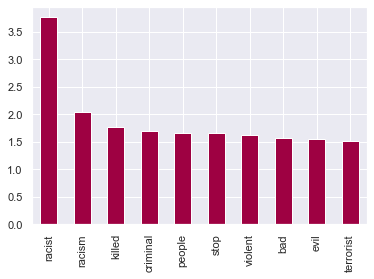

In [78]:
df_CV[1].sort_values(ascending=False).head(10).plot(kind='bar', cmap='Spectral')

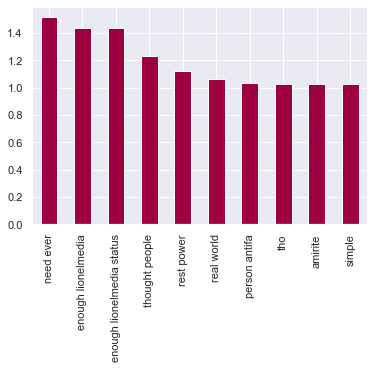

In [79]:
df_CV[2].sort_values(ascending=False).head(10).plot(kind='bar', cmap='Spectral')

## Getting the SVM coefficients for each class 

In [80]:
svm_clf=svm.SVC(kernel='linear', C=10)

In [81]:
svm_clf.fit(tfidf_data_train_lem, y_train)

SVC(C=10, kernel='linear')

In [82]:
svm_clf.coef_.T.shape
data3=tfidf.get_feature_names()

In [83]:
len(data3)

54344

In [84]:
svm_clf.coef_.T.shape

(54344, 3)

In [85]:
data2=pd.DataFrame(svm_clf.coef_.T.todense(), index= data3)

data2.rename(columns={0:'positive', 1:'negative', 2:'neutral'}, inplace=True)


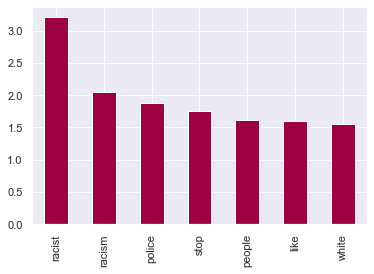

In [86]:
data2['positive'].sort_values(ascending=False).head(7).plot(kind='bar', cmap='Spectral')


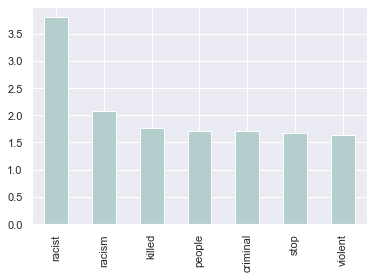

In [87]:
data2['negative'].sort_values(ascending=False).head(7).plot(kind='bar', color = '#B4CDCD')

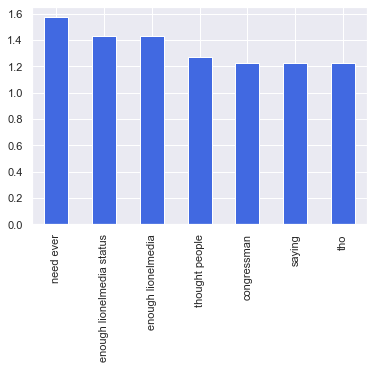

In [88]:
data2['neutral'].sort_values(ascending=False).head(7).plot(kind='bar', color= '#4169E1' )

In [89]:
# result=pd.read_csv('twitter.csv')

In [90]:
# result['tweet']

In [91]:
# result_main= result[result['language']=='en']

In [92]:
# result_main['language'].value_counts()

In [93]:
# holdout_result=NLP_process(result_main['tweet'])

In [94]:
# c= [analyser.polarity_scores(x) for x in result_main['tweet']]

In [95]:
# d= [x.items() for x in a]

In [96]:
# data2=pd.DataFrame(d, columns= ['neg', 'neu', 'pos', 'comp'])

In [97]:
# e = data2['comp']

In [98]:
# data2['comp2']= [score[1] for score in e]

In [99]:
# data2['comp2']= data2['comp2'].round(3)

In [100]:
#converting the vader scores into something easier to manipulate so that I can generate 
#three distinct classes
# col         = 'comp2'
# conditions  = [ data2[col] >= .05, (data2[col] < .05) & (data2[col]> -.05), data2[col] <= -.05 ]
# choices     = [ 1, 0, -1 ]
# data2["comp3"] = np.select(conditions, choices, default=np.nan)

In [101]:
# data2['comp4']= data2['comp3'].map({-1:'negative', 0: 'neutral', 1:'positive'})

In [102]:
# data2['comp4'].value_counts()

In [103]:
# y_holdout=data2['comp4']

In [104]:
# X_holdout=result['tweet']

In [105]:
# tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), lowercase=True)
# tfidf_holdout_set = tfidf.fit_transform(X_holdout)
# # tfidf_holdout_set = tfidf.transform(X_holdout)

# # tfidf_data_train_lem
# dfq1 = pd.DataFrame(tfidf_holdout_set.toarray().transpose(),
#                  index = tfidf.get_feature_names())

# The rest of NB deals with advanced NLP topics

In [106]:
import spacy
import pandas as pd
import numpy as np
from tqdm import tqdm

In [107]:
tqdm.pandas()

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [108]:
Work_data

,tweet,language,comp4
0,https://twitter.com/drawandstrike/status/1279...,en,negative
1,RACISM IS THE IDOL THAT FEEDS THE BEAST OF #b...,en,negative
2,Powerful picture of the REAL state of race rel...,en,positive
3,Looks like yet another black criminal dealt wi...,en,negative
4,"I SAW YOU ON THE NEWS, KNOW THE TRUTH AND YOUR...",en,positive
...,...,...,...
7131,For all the #AllLivesMatter people.. I’m gonna...,en,negative
7133,@ericgarcetti what did you expect moron? we'r...,en,negative
7134,Does that mean #DementiaJoe is saying #AllLive...,en,negative
7135,#PaperMario #PaperMarioTheOrigamiKing #Nintend...,en,positive


## Attempting to use SpaCY

In [109]:
nlp = spacy.load('en_core_web_md')

In [110]:
Work_data['spacy_txt'] = [nlp(x) for x in Work_data['tweet']]

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [111]:
#made a column containing a spacy object
Work_data['spacy_y']= [nlp(x) for x in Work_data['comp4']]

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [112]:
# corpus = []
# for doc in nlp_df.clean_tweet:
#     d = (list(filter(lambda x: x.is_stop==False,nlp(doc))))
#     d = (list(filter(lambda x: x.is_punct==False, d)))
#     d = (list(filter(lambda x: x.like_url==False, d)))
#     d = (list(map(lambda x: x.lemma_, d)))
#     corpus.append(d)

NameError: name 'nlp_df' is not defined

In [113]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—', '.']
sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter', 'p']
sw_set = set(sw_list)

In [114]:
Work_data.spacy_txt[0] 

 https://twitter.com/drawandstrike/status/1279805238556397569?s=19 …

Let me know when BLM marxist scum is marching for this little girl and the 6000+ black people murdered by other black people in the US every year. Till then... #AllLivesMatter

In [115]:
pd.DataFrame(np.vstack([x.vector for x in Work_data.spacy_txt]))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.085737,0.110011,-0.098758,-0.054373,0.118368,-0.061138,-0.033711,-0.051620,0.033901,1.705545,...,-0.205212,-0.028773,0.041361,-0.117117,0.030683,-0.005308,-0.038505,0.005734,-0.104009,0.059712
1,-0.101225,0.144536,0.013526,-0.035605,0.022171,0.017819,0.105060,-0.050106,-0.044673,1.376224,...,-0.083363,0.015928,-0.060653,-0.090165,-0.003579,0.072440,-0.052131,-0.010314,-0.095380,0.018385
2,-0.108945,0.044877,-0.012569,-0.057276,-0.022530,-0.021131,0.076258,0.085494,0.044478,1.392057,...,-0.227196,0.021466,-0.039269,-0.097682,-0.015729,-0.000722,0.028467,0.025216,-0.067488,-0.011271
3,-0.225504,0.096830,-0.093529,-0.036587,0.082241,-0.060542,0.060585,-0.056602,-0.032591,2.156984,...,-0.234631,0.038597,-0.064123,-0.104161,-0.026616,0.128268,0.016932,-0.102231,-0.033816,0.070872
4,-0.133796,0.173658,-0.112062,-0.037270,-0.006774,0.032994,0.032324,-0.100356,-0.020360,1.843828,...,-0.222946,-0.026328,-0.026978,0.046277,0.077939,-0.032485,-0.033669,-0.068939,-0.018434,0.119203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4876,-0.089414,0.093741,-0.106014,-0.020301,0.084784,-0.043541,0.064574,-0.099007,0.006676,1.520338,...,-0.063661,-0.004767,-0.068518,-0.110241,0.114712,0.026091,-0.079182,-0.048956,-0.070506,0.046938
4877,-0.102344,0.195423,-0.144840,-0.051655,0.081779,-0.078952,0.053196,-0.008318,0.024424,1.927606,...,-0.127079,0.111543,-0.034199,-0.071530,0.053319,0.005190,-0.118614,-0.000518,-0.015575,0.065249
4878,-0.133181,0.189020,-0.058354,-0.039268,0.059520,-0.065873,0.025434,-0.027814,-0.066679,1.838957,...,-0.078801,0.009704,-0.049034,-0.072681,0.111523,-0.008624,-0.114201,-0.009139,-0.008979,0.019728
4879,-0.155865,0.253775,0.119925,0.008229,0.016805,-0.069003,0.188164,0.013017,-0.016306,0.755434,...,-0.015028,0.065568,-0.044338,0.024901,0.126876,-0.127993,-0.086022,-0.073615,-0.165799,-0.058263


In [116]:
X=Work_data.spacy_txt
y=Work_data.spacy_y

In [117]:
def mean_tweet_length(X):
    for token in X:
        print (token.__len__())

## Topic Modeling using LDA and NMF

In [200]:
#First we vectorize data
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=sw_list, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(Work_data['tweet'])
data_vectorized.shape

(4881, 2349)

In [119]:
#select number of topics or clusters of data
NUM_TOPICS = 3

In [120]:
#importing libraries
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

In [121]:
#instantiating lda model with certain hyperparamters
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, n_jobs=-1, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [154]:
#function that returns the topic and important features to that topic
def selected_topics(model, vectorizer, top_n=15):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 


In [155]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('status', 616.3965970602608), ('trump', 371.60803006157556), ('pic', 275.16005553599155), ('maga', 192.04746352206885), ('backtheblue', 176.92455943491595), ('police', 164.15768244041928), ('wwg', 132.73673695917563), ('blm', 129.91423990226147), ('right', 124.79791930362767), ('people', 110.69506927822376), ('blmterrorists', 109.78698076093569), ('let', 109.03333853209597), ('support', 104.8157888225749), ('wga', 102.67851832280195), ('america', 99.46124276437355)]
Topic 1:
[('lives', 640.7720104822829), ('black', 574.0959489050505), ('matter', 530.9832458237091), ('people', 447.9825020561675), ('status', 422.54197194880857), ('racist', 296.0109001656079), ('pic', 292.97689509663905), ('white', 265.5002468022487), ('like', 221.02870697139952), ('blm', 183.9951142897759), ('say', 155.40777110036092), ('think', 128.88119644111117), ('love', 126.66124453269533), ('saying', 126.40178902790862), ('get', 115.89771829917275)]
Topic 2:
[('realdonaldtrump', 433.8372683449

In [312]:
#created dictionary of lda components and the words
a= dict(zip(vectorizer.get_feature_names(), lda.components_[0]))

In [313]:
#sorted dictionary from highest to lowest
sort_ordersa = sorted(a.items(), key=lambda x: x[1], reverse=True)


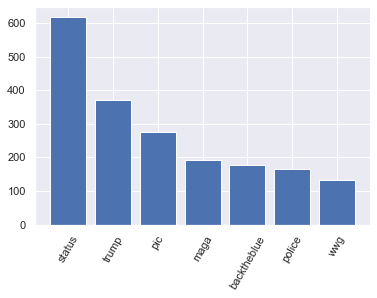

In [338]:
#graph of topic 0
#POSITIVE SENTIMENT
a=dict(sort_ordersa[0:7])
F, G = zip(*a.items()) # unpack a list of pairs into two tuples
plt.savefig('LDApos1.png')
plt.bar(F, G)
plt.xticks(rotation=60)
plt.show()

In [124]:
lda.components_

array([[ 0.33379848,  0.33595338, 26.66566905, ...,  0.38337168,
         0.333573  ,  0.3342357 ],
       [ 0.33965649,  0.34988893,  0.38369168, ...,  0.40543565,
         0.33900981,  0.33965446],
       [ 5.87749289, 26.68350535, 16.72709014, ..., 33.49677225,
        13.00164208,  7.0074492 ]])

In [125]:
#Instantiating the NMF model with certain hyperparamters
nmf=NMF(n_components = NUM_TOPICS, random_state =1, alpha=0.1, l1_ratio = 0.5, 
        init= 'nndsvd').fit(data_vectorized)

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [126]:
# returning topic and important words associated with the topic
print("NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('lives', 5.844655232342381), ('black', 4.83530550054908), ('matter', 4.825281211290751), ('people', 1.1763357651513195), ('white', 1.0968776080180784), ('say', 0.5158146309819348), ('even', 0.4502133509151366), ('life', 0.36795780723059607), ('racist', 0.34009217136396885), ('saying', 0.33218353264158396), ('utm', 0.3058112219284762), ('matters', 0.2810986007766448), ('like', 0.2803740313019304), ('blacks', 0.2781814697127207), ('blue', 0.2572378682955275)]
Topic 1:
[('blm', 3.600133988178728), ('pic', 3.5124199698870364), ('realdonaldtrump', 3.4526532271019392), ('cspanwj', 2.225088800460473), ('news', 2.1316046227823295), ('facebook', 2.1157901703138524), ('breakingnews', 2.0637462503414925), ('breaking', 1.6053156477099073), ('teaparty', 1.5578033093641261), ('hate', 1.4574009788692899), ('tcot', 1.2813319104108356), ('racist', 1.2728999094263551), ('terrorist', 1.0462154886797208), ('group', 0.9696626332919562), ('target', 0.9422964794312984)]
Topic 2:
[('stat

In [221]:
#created a dictionary 
g=dict(zip(vectorizer.get_feature_names(), lda.components_[1]))  
g

{'--atuq': 0.33965649300322376,
 '-cops-protect-black-lives-matter-mural': 0.3498889292605484,
 'abcnews': 0.383691681274128,
 'abiding': 6.045763415748457,
 'ability': 14.685916765713417,
 'able': 3.2897822439683186,
 'aboriginallivesmatter': 0.3340358415701477,
 'abortion': 0.36157514214433967,
 'abortionismurder': 0.34172718455392453,
 'absolute': 0.34560749030046894,
 'absolutely': 0.44686997291017266,
 'abt': 6.714873734321465,
 'abused': 16.483018256742884,
 'acab': 4.5031143305382395,
 'accepted': 3.6142991985724966,
 'account': 0.34619713510355526,
 'across': 0.34687258433598617,
 'act': 0.3419209472721763,
 'actions': 4.959770001701396,
 'activists': 0.36241028182946866,
 'acts': 0.38361311444935337,
 'actual': 6.0500612971683845,
 'actually': 0.3662476872065991,
 'add': 9.129636237892822,
 'afp': 0.37660548502781005,
 'afraid': 0.3446728989452324,
 'africa': 0.47208133224549703,
 'african': 14.807535907901707,
 'african-americans': 0.42999760735900394,
 'agbecerra': 0.3339054

In [309]:
#sorted thru dictionary grom highest to lowest
sort_ordersp = sorted(g.items(), key=lambda x: x[1], reverse=True)


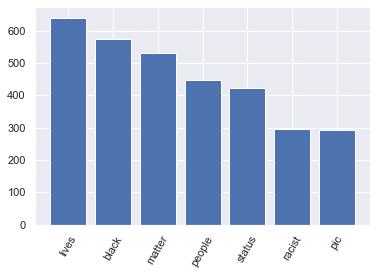

In [339]:
#NEGATIVE SENTIMENT
#graph of the words in topic 1
p=dict(sort_ordersp[0:7])
F, G = zip(*p.items()) # unpack a list of pairs into two tuples
plt.savefig('LDAneg1.png')
plt.bar(F, G)
plt.xticks(rotation=60)
plt.show()

In [332]:
o=dict(zip(vectorizer.get_feature_names(), lda.components_[2]))  
o

{'--atuq': 5.877492892130216,
 '-cops-protect-black-lives-matter-mural': 26.683505354958665,
 'abcnews': 16.72709013692268,
 'abiding': 0.538623292272635,
 'ability': 0.3335492414808504,
 'able': 6.164230988864189,
 'aboriginallivesmatter': 0.3407314805435395,
 'abortion': 8.444347736334183,
 'abortionismurder': 5.018593451762632,
 'absolute': 0.3356128593341346,
 'absolutely': 23.66178629759832,
 'abt': 0.334627774692167,
 'abused': 0.3420810462084616,
 'acab': 0.49390725763862503,
 'accepted': 1.7211758976598672,
 'account': 0.333910260397725,
 'across': 0.34273477891115706,
 'act': 0.33379379609476917,
 'actions': 0.36642432420217885,
 'activists': 5.047805050275463,
 'acts': 0.34829889016674875,
 'actual': 4.444954803176673,
 'actually': 0.3399331197849655,
 'add': 0.3336894242495105,
 'afp': 6.370969473207035,
 'afraid': 0.4453028578845601,
 'africa': 0.3336500313333077,
 'african': 0.3418341196726082,
 'african-americans': 0.33361070178045704,
 'agbecerra': 0.4806986492899641,
 '

In [333]:
#sorted dictionary from highest to lowest
sort_orders = sorted(o.items(), key=lambda x: x[1], reverse=True)

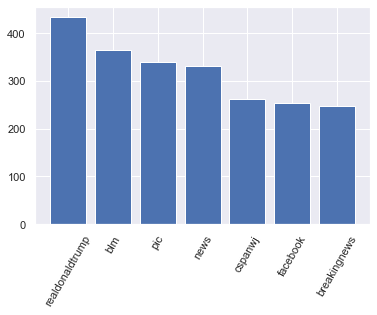

In [340]:
#graphing of topic 2
#NEUTRAL SENTIMENT
o=dict(sort_orders[0:7])
# o_items()
x, y = zip(*o.items()) # unpack a list of pairs into two tuples
plt.savefig('LDA_neu2.png')
plt.bar(x, y)
plt.xticks(rotation=60)
plt.show()

In [305]:
o.items()

dict_items([('realdonaldtrump', 433.8372683449752), ('blm', 364.5553679868413), ('pic', 339.2168091211867), ('news', 330.2666911218312), ('cspanwj', 262.6373683043683), ('facebook', 254.11714838885501), ('breakingnews', 246.17764263580818)])

In [127]:
# was able to calculate mean word length of all tweets
Sum=162388
length_numbers=4881

In [128]:
mean= Sum/length_numbers
mean

33.26941200573653

### Implementing pyLDAvis in my EDA

In [345]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [344]:
! pip install pandas nltk gensim pyldavis
# Ignore warnings

     |████████████████████████████████| 1.6 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 548 kB 4.6 MB/s eta 0:00:01     |███████████████                 | 256 kB 4.6 MB/s eta 0:00:01
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=5d5e32a1629d6125ae02e8c8824521c6d0700d74b512a550746f6abefbb9aff7
  Stored in directory: /Users/jeffreyng/Library/Caches/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=3eb6c98b630c240c7639982c3e5e06c46b3d05bd05861143e30461bd030ba1a8
  Stored in directory: /Users/jeffreyng/Library/Caches/pip/wheels/3c/33/97/805b282e129f60bb4e87cea622338f30b65f21eaf65219971f
Successfully built pyldavis funcy


In [445]:
#importing necessary libraries
#the cleaning function
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stopwords = list([stopwords.words('english'),'alllivesmatter', 'blacklivesmatter', 'alllivesmatter'] )
stopwords += ['alllivesmatter', 'blacklivesmatter', 'alllivesmatter']
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()

def cleaning(article):
    one = " ".join([i for i in article.lower().split() if i not in stopwords])
    two = "".join(i for i in one if i not in punctuation)
    three = " ".join(lemmatize.lemmatize(i) for i in two.split())
    return three


In [446]:
#cleaning data and preprocessing
text = [cleaning(x) for x in Work_data['tweet']]
text_list = [i.split() for i in text]
len(text_list)

4881

In [447]:
text_list[0]

['httpstwittercomdrawandstrikestatus1279805238556397569s19',
 '…',
 'let',
 'me',
 'know',
 'when',
 'blm',
 'marxist',
 'scum',
 'is',
 'marching',
 'for',
 'this',
 'little',
 'girl',
 'and',
 'the',
 '6000',
 'black',
 'people',
 'murdered',
 'by',
 'other',
 'black',
 'people',
 'in',
 'the',
 'u',
 'every',
 'year',
 'till',
 'then',
 'alllivesmatter']

In [431]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our corpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')


TypeError: 'tuple' object is not callable

In [432]:
# creating and saving corpus to be used in the pyLDAvis  
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)


TypeError: 'tuple' object is not callable

In [433]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [434]:
#Coding for the pyLDAviz
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
vis = pyLDAvis.gensim.prepare(ldamodel, c, d)
vis

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.072598 -0.052532       1        1  20.971527
4      0.089494 -0.021953       2        1  13.542147
2      0.031480  0.030884       3        1  13.453043
5     -0.031809  0.090002       4        1  10.847891
8      0.083696 -0.080109       5        1   9.161586
7      0.049420  0.056271       6        1   9.060246
3     -0.045638  0.145281       7        1   7.836730
6      0.015124 -0.115658       8        1   6.843086
1     -0.046943  0.050599       9        1   4.683916
9     -0.217422 -0.102785      10        1   3.599828, topic_info=    Category         Freq            Term        Total  loglift  logprob
1    Default  4325.000000  alllivesmatter  4325.000000  30.0000  30.0000
277  Default   193.000000    breakingnews   193.000000  29.0000  29.0000
281  Default   199.000000         cspanwj   199.000000  28.0000  28.0000
282  Default   195.000000        facebook   195.000000  27.0000  27.0000
406  Default   215.000000            hate   215.000000  26.0000  26.0000
..       ...          ...             ...          ...      ...      ...
57   Topic10    16.842125          matter   491.266998  -0.0488  -5.0999
216  Topic10    13.810518           right   205.442017   0.6246  -5.2984
13   Topic10    12.920092          people   553.939758  -0.4340  -5.3650
426  Topic10    12.127381          police   283.988617   0.1708  -5.4284
26   Topic10    12.015386            life   736.531372  -0.7915  -5.4376

[708 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
233       1  0.235886       1
233       3  0.117943       1
233       4  0.058972       1
233       5  0.137600       1
233       6  0.078629       1
...     ...       ...     ...
5861      5  0.956102      ⁠⁠
2707      9  0.866185  🇺🇸🇺🇸🇺🇸
3882      6  0.945355       🐾
1095      4  0.953664     😂😂😂
5275      7  0.879686       😷

[1598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 6, 9, 8, 4, 7, 2, 10])

### ^^^ The pyLDAvis using Gensim